In [1]:
import os
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#load datasets

airbnb_crime = pd.read_csv('cleaned_airnb_crime.csv')


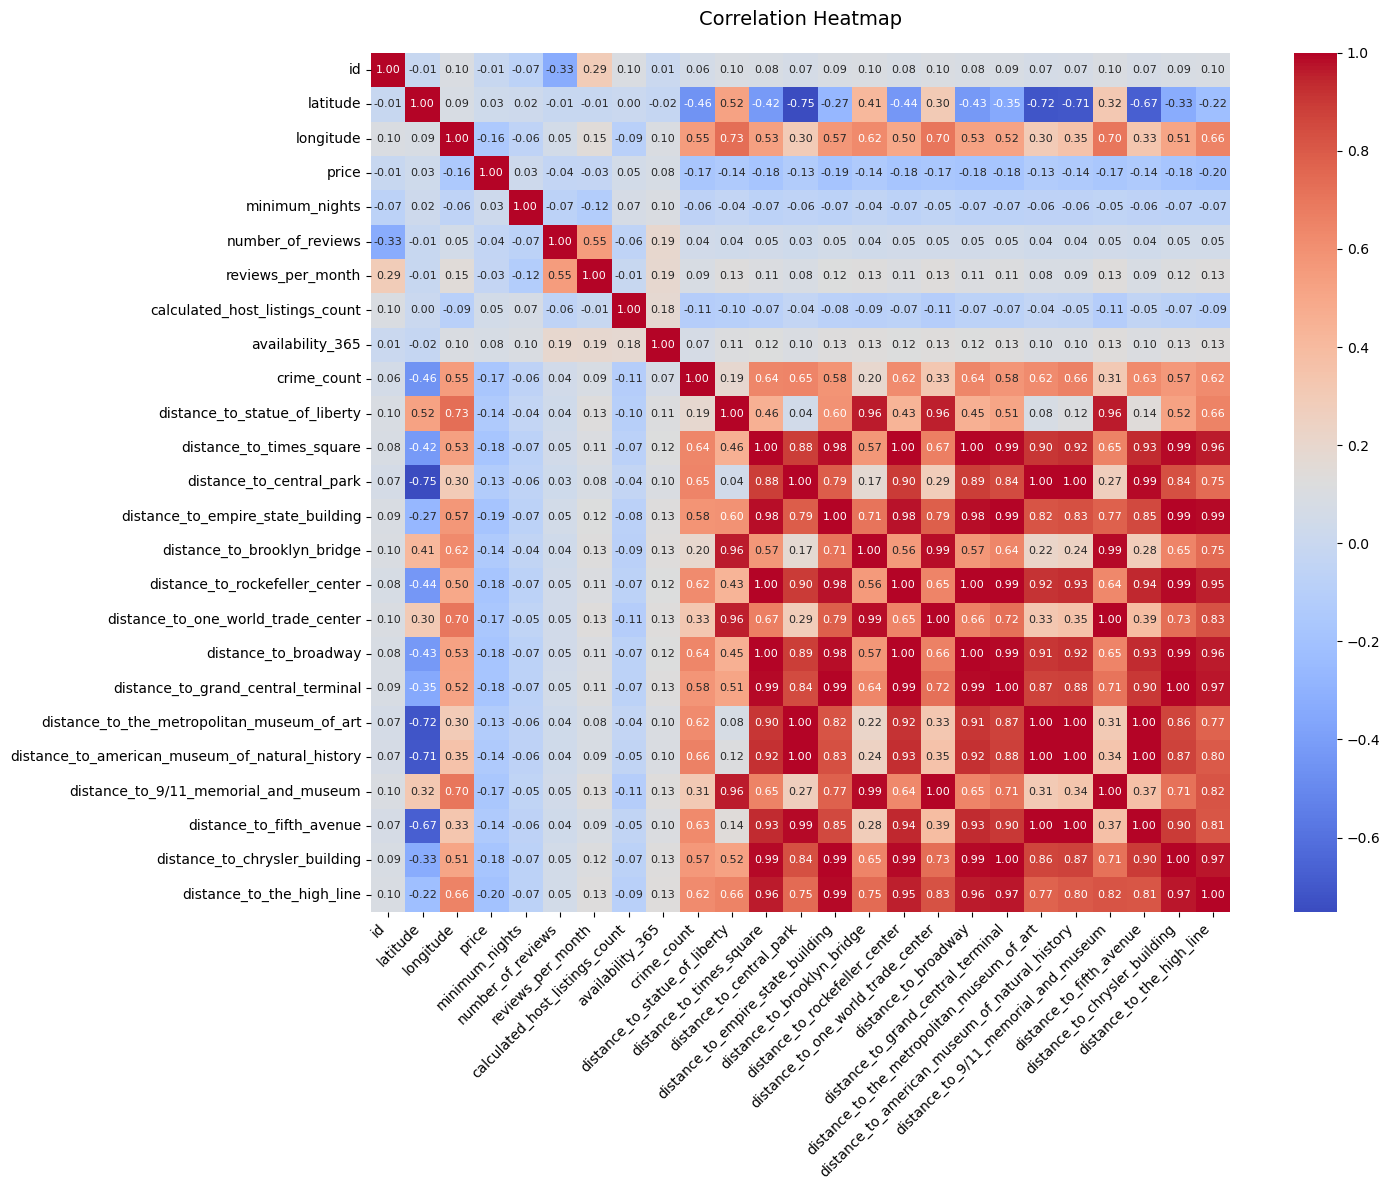

In [2]:
#Correlation Heatmap to visualize relationships between numeric features to select features for ML model

# Select numeric columns
numeric_cols = airbnb_crime.select_dtypes(include=[np.number])

# Compute correlations
corr = numeric_cols.corr()

# Set up figure size
plt.figure(figsize=(16, 12))

# Plot heatmap
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f",       # show 2 decimal places
    cmap="coolwarm", # color palette
    cbar=True, 
    square=True, 
    annot_kws={"size": 8}  # smaller font for annotations
)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title("Correlation Heatmap", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


OBS: Features we will keep: latitude, longitude, minimum_nights, number_of_reviews, availability_365, crime_count, calculated_host_listings_count, 
distance_to_statue_of_liberty, distance_to_times_square.

In [3]:
X = airbnb_crime[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'availability_365', 'crime_count',
               'calculated_host_listings_count', 'distance_to_statue_of_liberty', 'distance_to_times_square', 'neighbourhood_group', 'room_type']]
y = airbnb_crime['price']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select only numeric columns
numeric_features = ['latitude', 'longitude', 'minimum_nights', 
                    'number_of_reviews', 'availability_365', 'crime_count',
                    'calculated_host_listings_count', 
                    'distance_to_statue_of_liberty', 'distance_to_times_square']

scaler = MinMaxScaler()
scaler.fit(X_train[numeric_features])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Replace numeric columns with scaled versions
X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])


In [6]:
# Put transformed data into a DataFrame (only numeric features)
X_train_transformed = pd.DataFrame(scaler.transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)
X_test_transformed = pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features, index=X_test.index)

In [7]:
# neighbourhood_group - nominal -> One Hot Encoding
airbnb_crime.neighbourhood_group.value_counts(dropna=False)

neighbourhood_group
Manhattan        16621
Brooklyn         16439
Queens            4572
Bronx              875
Staten Island      314
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(drop='first')
oh_encoder.fit(airbnb_crime.loc[X_train.index, ['neighbourhood_group']])

X_train_encoded = pd.DataFrame.sparse.from_spmatrix(
    oh_encoder.transform(airbnb_crime.loc[X_train.index, ['neighbourhood_group']]),
    columns=oh_encoder.get_feature_names_out(),
    index=X_train.index
)
X_test_encoded = pd.DataFrame.sparse.from_spmatrix(
    oh_encoder.transform(airbnb_crime.loc[X_test.index, ['neighbourhood_group']]),
    columns=oh_encoder.get_feature_names_out(),
    index=X_test.index
)

X_train_encoded = pd.concat([X_train_encoded, X_train_transformed], axis=1)
X_test_encoded = pd.concat([X_test_encoded, X_test_transformed], axis=1)

In [9]:
# room_type- ordinal -> Label Encoding
airbnb_crime.room_type.value_counts(dropna=False)

room_type
Entire home/apt    20321
Private room       17654
Shared room          846
Name: count, dtype: int64

In [10]:
from sklearn.preprocessing import OrdinalEncoder

l_encoder = OrdinalEncoder()
l_encoder.fit(airbnb_crime.loc[X_train.index, ['room_type']]) # input needs to be a dataframe, not a series
X_train_label = l_encoder.transform(airbnb_crime.loc[X_train.index, ['room_type']]) # need to have the same cols for transformation as we did for training

l_encoder.fit(airbnb_crime.loc[X_test.index, ['room_type']]) # input needs to be a dataframe, not a series
X_test_label = l_encoder.transform(airbnb_crime.loc[X_test.index, ['room_type']]) # need to have the same cols for transformation as we did for training

X_train_label = pd.DataFrame(X_train_label, columns=['room_type'], index=X_train.index)
X_test_label = pd.DataFrame(X_test_label, columns=['room_type'], index=X_test.index)

X_train_t = pd.concat([X_train_encoded, X_train_label], axis=1)
X_test_t = pd.concat([X_test_encoded, X_test_label], axis=1)


In [11]:
X_train_label['room_type'].value_counts()  # Check the count for unique values in room_type after encoding

room_type
0.0    16250
1.0    14143
2.0      663
Name: count, dtype: int64

In [12]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10) # n_neighbours is a "hyperparameter", which can be changed to improve performance of the model
knn.fit(X_train_t, y_train)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KNeighborsRegressor(n_neighbors=10)

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_t, y_train)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


LinearRegression()

In [14]:
# Score the model
knn.score(X_test_t, y_test)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.1560925571255739

In [15]:
lr.score(X_test_t, y_test)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.1508521427765772

In [16]:
#==============================================================================5th Linear Regression Model============================================================

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True)

In [18]:
lin_reg.fit(X_train_t, y_train)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


LinearRegression()

In [19]:
print(lin_reg.score(X_train_t, y_train)) # R2 = 0.61 -> 61 on practice test 
print(lin_reg.score(X_test_t, y_test)) 

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.11509218458847825
0.1508521427765772


c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [20]:
lin_reg.feature_names_in_

array(['neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'availability_365', 'crime_count',
       'calculated_host_listings_count', 'distance_to_statue_of_liberty',
       'distance_to_times_square', 'room_type'], dtype=object)

In [21]:
lin_reg.coef_

array([-7.29915538e+12, -1.94596785e+13, -1.36214611e+12, -5.18636480e+12,
       -8.25560240e+01,  2.58622791e+01, -2.04167023e+02, -1.26598338e+02,
        6.73954872e+01, -1.94596785e+13, -3.81926313e+01, -7.86878787e+01,
       -1.39436784e+02, -9.08029423e+01])

In [22]:
import plotly.express as px
px.histogram(x=lin_reg.coef_, y=lin_reg.feature_names_in_)

In [23]:
#============================================================ 6th Decision Tree Model ============================================================

In [24]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(
    max_depth=10, # 30, 50, 100 - we can have many more splits when we have continuous variables
    min_samples_split=2,
    max_leaf_nodes=30 # basically equivalent to max_depth but still considered
)

In [25]:
dt_reg.fit(X_train_t, y_train)

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



DecisionTreeRegressor(max_depth=10, max_leaf_nodes=30)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = dt_reg.predict(X_test_t)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 33628.446100193694
RMSE: 183.3806044820272
MAE: 58.18598071659245
R²: -0.005299556840179465


c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\Naveen\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

